In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.5.0"  # Change this path according to your R installation.
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter



In [7]:
# Enable conversion between pandas and R
pandas2ri.activate()

# Load required packages
base = importr("base")
utils = importr("utils")
dplyr = importr("dplyr")
ggplot2 = importr("ggplot2")
tidyr = importr("tidyr")
copula = importr("copula")
fitdistrplus = importr("fitdistrplus")
evd = importr("evd")
readr = importr("readr")
pacman = importr("pacman")


In [8]:
# R code as string
r_code = """
suppressMessages({
  pacman::p_load(dplyr, ggplot2, tidyr, copula, fitdistrplus, evd, readr)
})
# Data path
l <- '../data/processed/'
ruta2 <- file.path(l, "covid_data_with_6_states.csv")
covid_data <- read.csv(ruta2)
covid_data$Date <- as.Date(covid_data$Date)
covid_data$Commune <- as.factor(covid_data$Commune)

# Target communities
communes_target <- c("La Florida", "Cerrillos", "Vitacura", "Providencia", "Las Condes", "Santiago", "Puente Alto", "Maipu")
vars <- c("Gross_Daily_Cases_Mobile_Average_7_Days", "Internal_Mobility_Index", "External_Mobility_Index")

# Ranking of states
state_ranking <- covid_data %>%
  group_by(Hidden_State) %>%
  summarise(average_cases = mean(Gross_Daily_Cases_Mobile_Average_7_Days, na.rm = TRUE)) %>%
  arrange(desc(average_cases)) %>%
  mutate(weight = case_when(
    row_number() == 1 ~ 10,
    row_number() == 2 ~ 6,
    row_number() == 3 ~ 4,
    row_number() == 4 ~ 2,
    TRUE ~ 1
  ))

weights_state <- setNames(state_ranking$weight, state_ranking$Hidden_State)

copulas_list <- list()
gpd_fits <- list()

for (com in communes_target) {
  for (state in sort(unique(covid_data$Hidden_State))) {
    subset <- covid_data %>%
      filter(Commune == com, Hidden_State == state) %>%
      dplyr::select(all_of(vars))

    if (state %in% names(weights_state)) {
      weight <- weights_state[as.character(state)]
      subset <- subset[rep(1:nrow(subset), each = weight), ]
    }

    if (nrow(subset) > 30) {
      u_data <- pobs(as.matrix(subset))
      cop <- tCopula(dim = 3, df = 5, dispstr = "un")
      fit <- fitCopula(cop, u_data, method = "ml", start = c(0.5, 0.5, 0.5, 5))

      threshold <- quantile(subset[[1]], 0.90, na.rm = TRUE)
      ecdf_body <- ecdf(subset[[1]])
      excesses <- subset[[1]][subset[[1]] > threshold] - threshold
      gpd_model <- NULL

      if (length(excesses) > 20) {
        gpd_model <- fpot(subset[[1]], threshold = threshold, model = "gpd", std.err = FALSE)
      }

      copulas_list[[paste0(com, "_State", state)]] <- list(
        copula = fit@copula,
        marginals = apply(subset, 2, ecdf),
        threshold = threshold,
        ecdf = ecdf_body
      )

      gpd_fits[[paste0(com, "_State", state)]] <- gpd_model
    }
  }
}

N_sim <- 200
simulations <- list()

for (com in communes_target) {
  data_com <- covid_data %>% filter(Commune == com)
  sim_matrix <- matrix(NA, nrow = nrow(data_com), ncol = N_sim)

  for (i in 1:N_sim) {
    sim_cases <- numeric(nrow(data_com))

    for (j in seq_len(nrow(data_com))) {
      st <- data_com$Hidden_State[j]
      key <- paste0(com, "_State", st)
      cop_info <- copulas_list[[key]]
      gpd_info <- gpd_fits[[key]]

      if (!is.null(cop_info)) {
        cop_fit <- cop_info$copula
        threshold <- cop_info$threshold
        ecdf_body <- cop_info$ecdf

        u_sample <- rCopula(1, cop_fit)
        case_u <- u_sample[1]

        if (!is.null(gpd_info) && case_u > ecdf_body(threshold)) {
          p_exceed <- (case_u - ecdf_body(threshold)) / (1 - ecdf_body(threshold))
          gpd_params <- gpd_info$estimate
          sim_excess <- qgpd(p_exceed, loc = 0, scale = gpd_params["scale"], shape = gpd_params["shape"])
          inv_case <- threshold + sim_excess
        } else {
          inv_case <- quantile(
            covid_data %>% filter(Commune == com, Hidden_State == st) %>% pull(vars[1]),
            probs = case_u, na.rm = TRUE
          )
        }

        sim_cases[j] <- inv_case
      } else {
        sim_cases[j] <- NA
      }
    }

    sim_matrix[, i] <- sim_cases
  }

  simulations[[com]] <- data.frame(Date = data_com$Date, Commune = com, sim_matrix)
}

# Export combined result
sim_df <- dplyr::bind_rows(simulations)
output_path <- file.path(l, "simulated_cases_severity_weighted_v2.csv")
write.csv(sim_df, output_path, row.names = FALSE)
"""

# Ejecutar código R
r(r_code)

output_path = "../data/processed/simulated_cases_severity_weighted_v2.csv"
output_path


R[write to console]: In addition: 
R[write to console]: There were 23 warnings (use warnings() to see them)
R[write to console]: 



'../data/processed/simulated_cases_severity_weighted_v2.csv'

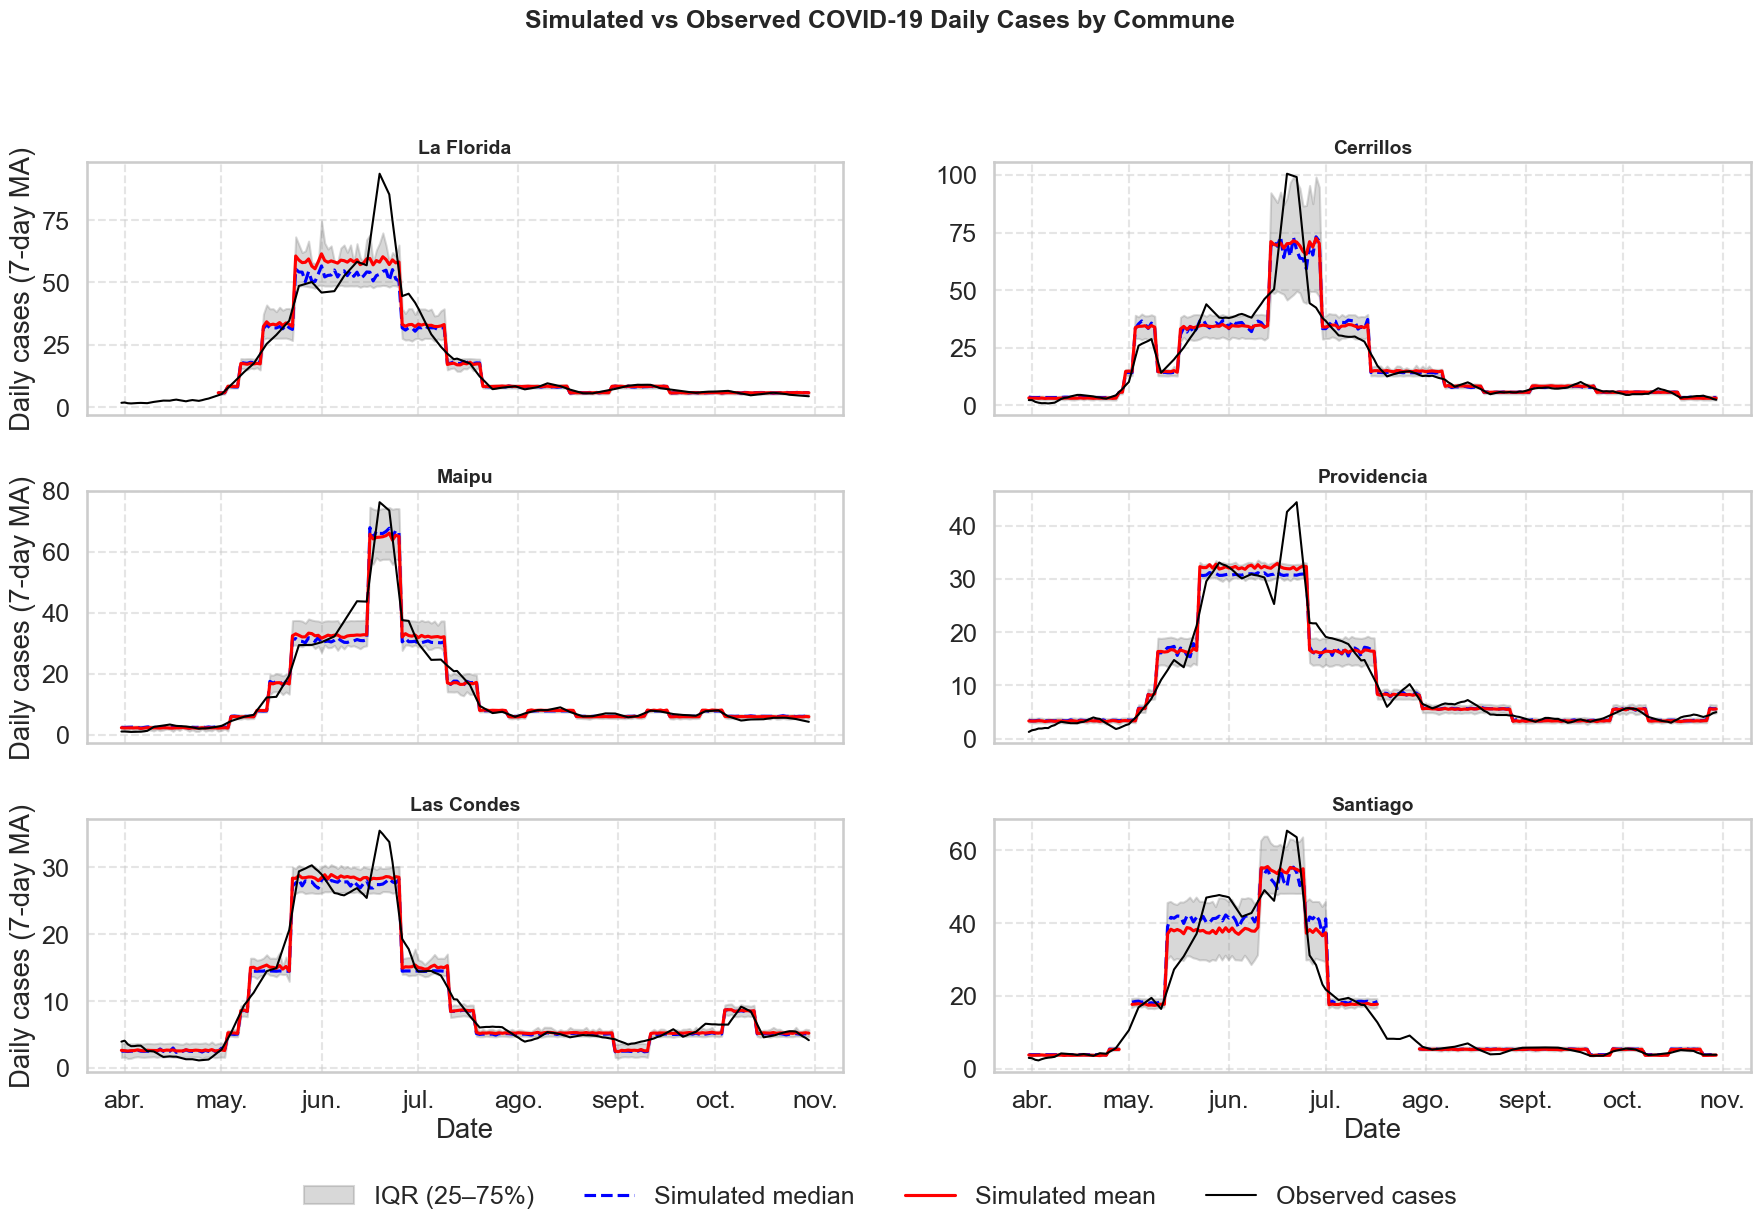

In [10]:
# Paths
sim_path = '../data/processed/simulated_cases_severity_weighted_v2.csv'
real_path = '../data/processed/covid_data_with_6_states.csv'

# Load data
sim_df = pd.read_csv(sim_path, parse_dates=["Date"])
real_df = pd.read_csv(real_path, parse_dates=["Date"])

# Target communes
target_communes = ["La Florida", "Cerrillos", "Maipu", "Providencia", "Las Condes", "Santiago"]

# Filter
sim_df = sim_df[sim_df["Commune"].isin(target_communes)]
real_df = real_df[real_df["Commune"].isin(target_communes)]

# Melt simulations
sim_cols = [col for col in sim_df.columns if col.startswith("X")]
sim_long = sim_df.melt(id_vars=["Date", "Commune"], value_vars=sim_cols,
                       var_name="Simulation", value_name="Sim_Cases")

# Plot settings
sns.set(style="whitegrid", context="talk", font_scale=1.1)
fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=True)
axes = axes.flatten()

for idx, commune in enumerate(target_communes):
    ax = axes[idx]
    sim_data = sim_long[sim_long["Commune"] == commune]
    real_data = real_df[real_df["Commune"] == commune]

    grouped = sim_data.groupby("Date")["Sim_Cases"]
    p25 = grouped.quantile(0.25)
    p75 = grouped.quantile(0.75)
    p50 = grouped.quantile(0.50)
    mean = grouped.mean()

    # Uncertainty band
    ax.fill_between(p25.index, p25, p75, color='gray', alpha=0.3, label="IQR (25–75%)")

    # Simulated median and mean
    ax.plot(p50.index, p50, linestyle='--', color='blue', label='Simulated median')
    ax.plot(mean.index, mean, linestyle='-', color='red', label='Simulated mean')

    # Observed data
    ax.plot(real_data["Date"], real_data["Gross_Daily_Cases_Mobile_Average_7_Days"],
            color='black', linewidth=1.5, label='Observed cases')

    # Format
    ax.set_title(commune, fontsize=14, weight='bold')
    ax.grid(True, linestyle='--', alpha=0.5)

    if idx % 2 == 0:
        ax.set_ylabel("Daily cases (7-day MA)")
    if idx >= 4:
        ax.set_xlabel("Date")

    # X-axis as month abbreviation
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# General legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, frameon=False, fontsize=18)

# Main title and layout
fig.suptitle("Simulated vs Observed COVID-19 Daily Cases by Commune", fontsize=18, weight='bold', y=1.02)
fig.tight_layout(rect=[0, 0.05, 1, 0.98])
fig.subplots_adjust(hspace=0.3, wspace=0.2)

# Save high-resolution figure
output_dir = '../results/figures/'
fig.savefig(f"{output_dir}copula_simulated_vs_real_cases_en.png", dpi=600)
fig.savefig(f"{output_dir}copula_simulated_vs_real_cases_en.pdf", dpi=600)

plt.show()
